# **Occupancy Trend Analysis of Rental Apartments**
* A quick look at occupancy trend in terms of:
 * Seasonality in a given year
 * Different locations and buildings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

data = pd.read_excel("Data_Test.xlsx")

## **Table basic info**
* data is anonymized except for ```contract_start, contract_end```, and possibly ```room_designation``` and ```flat_id```
* ```prospect_id``` is unique
* several low cardinality rows ```legal_entity, area_name, country_code, parent_id``` 
* ```room_designation``` has 912 missing values out of 2557 entries

In [3]:
data.head(3)

,room_designation,flat_id,legal_entity,area_name,building,customer_invoice_name,prospect_id,parent_id,contract_start,contract_end,first_name,last_name,country_code,assigned_to
0,XG_XXG_339JC_03-01_01,XG_XXG_339JC_03-01,-2474026488422860800,8911482309382230016,-269320407854525376,-6296112636846270464,2147440816,0,2017-10-01,2018-01-02,1804532529119746816,-7080105314284391424,4422705706840367104,8794469769934
1,XG_XXG_OS_45-03_03,XG_XXG_OS_45-03,-2474026488422860800,4412711573147853312,2553316829000431616,1920755500500865536,2147440961,0,2017-11-04,2018-01-02,2112491101215987456,-7251777801434685440,4422705706840367104,8794469769934
2,NaN,XG_XXG_ON-C_05-10,-8742682301542458368,-6459015886507585536,-473634675804173440,5075959393804346368,2147438757,0,2017-12-03,2018-01-02,8799131116189437952,6151051033233982464,4422705706840367104,4532170481802019840


In [4]:
print("total rows: {}".format(len(data)))

total rows: 2557


In [5]:
# unique values
pd.DataFrame(data.nunique(), columns=['unique entries'])

,unique entries
room_designation,777
flat_id,547
legal_entity,5
area_name,40
building,153
customer_invoice_name,2036
prospect_id,2557
parent_id,65
contract_start,782
contract_end,721


In [6]:
# empty rows
data.isna().sum()[data.isna().sum() != 0]

room_designation    912
dtype: int64

---

## **Preprocessing**
* Calculate contract duration (days)
* Add contract category: ```long_term_contract``` (1 = more than 5\*365 days | 0 = 5\*365 days or less)

Histogram of Contract Length (Days)


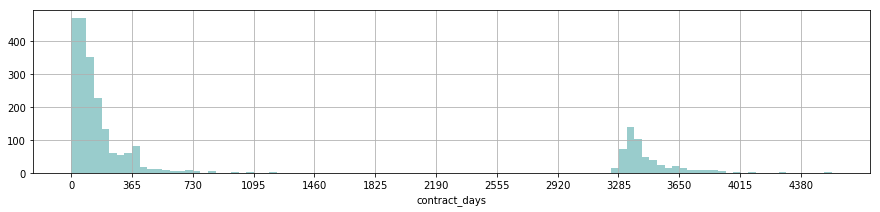

In [23]:
data['contract_days'] = (data['contract_end'] - data['contract_start']).astype(str).str.split().str[0].astype(int)
data.loc[data['contract_days'] < 0, 'contract_days'] = 0
plt.figure(figsize=(15,3))
minor_ticks = np.arange(0, 13*365, 365)
ax = sns.distplot(data['contract_days'], bins=100, kde=False, color='teal')
ax.set_xticks(minor_ticks)
ax.grid(which='both')
print('Histogram of Contract Length (Days)')

**Two distributions:**
* long term contracts (~10 years)
* short term ones (mostly < 1 year)
* one entry is -305 days (set to 0 for now)

In [25]:
#add long_term_contract column
data['long_term_contract'] = 0
data.loc[data['contract_days'] > 5*365, 'long_term_contract'] = 1

---

## **Active Contracts (i.e. Occupancy) Trends**

In [24]:
def get_daterange(row):
    return [x for x in pd.date_range(row[0], row[1])]

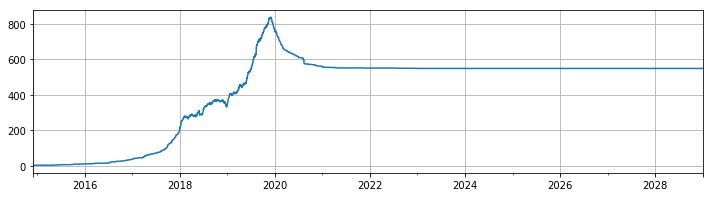

In [143]:
total_contract_dates = pd.DataFrame(data[['contract_start','contract_end']].apply(get_daterange, axis=1).tolist()).T.apply(pd.value_counts)
total_contract_dates = total_contract_dates.count(axis=1)
total_contract_dates.plot(figsize=(12,3), grid=True);

**Observations:**
* Sharp growth in late 2017
* Sharp growth since mid-2019 until now
* The long tail is due to the long-term contracts

In [58]:
def contracts_by_day(data, country_code):
    dates = pd.DataFrame(data[data['country_code']==country_code][['contract_start','contract_end']].apply(get_daterange, axis=1).tolist()).T.apply(pd.value_counts)
    return pd.DataFrame(dates.count(axis=1), columns=[country_code])

In [59]:
cc = data['country_code'].unique()
dates = [None] * 3
dates[0] = contracts_by_day(data, cc[0])
dates[1] = contracts_by_day(data, cc[1])
dates[2] = contracts_by_day(data, cc[2])

In [60]:
def merge_outer_index(a, b):
    return a.merge(b,left_index=True, right_index=True, how='outer')

### **Breaking down active contracts by country**

Stacked area plot of active contracts, by country


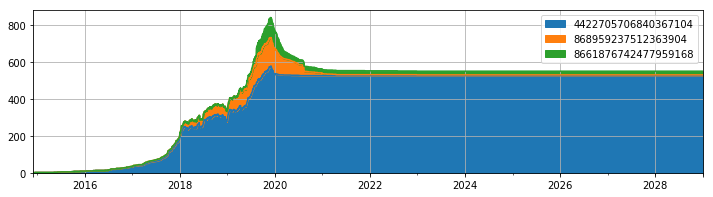

In [68]:
contract_dates = merge_outer_index(merge_outer_index(dates[0], dates[1]), dates[2])
contract_dates.plot.area(figsize=(12,3), grid=True);
print("Stacked area plot of active contracts, by country")

### **Seasonality Trends**
* compare the no. of active contracts during the years (range normalized from 0-1)

In [224]:
total_contract_years = pd.DataFrame(total_contract_dates)
total_contract_years['year'] = total_contract_dates.index.year
total_contract_years['dayofyear'] = total_contract_years.index.dayofyear

In [225]:
def norm_range(col):
    s = col.max() - col.min()
    return (col - col.min())/s

Normalized active contract, by year


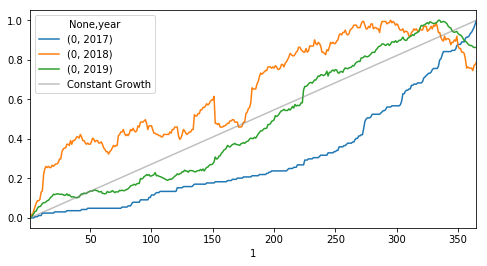

In [231]:
#range of interest
rg = range(2017,2019+1)
ax = total_contract_years[total_contract_years.year.isin(rg)].pivot(columns='year', index='dayofyear').apply(norm_range).plot(figsize=(8,4));
pd.DataFrame([[1,365],[0,1]]).set_index(1).rename(columns={0:"Constant Growth"}).plot(ax=ax, color='grey', alpha=0.5);
print("Normalized active contract, by year")

**Observations:**
* in 2018 and 2019, we see a dip in active contracts in th elast month
* *Note: above the gray line --> faster than constant growth*

---

## **Exploration by country**
* There are 3 countries (which I'm guessing are Singapore, Hong Kong and Australia).
* Most transactions come from one country

Building count by country


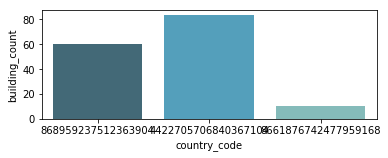

In [134]:
building_country = data[['country_code','building']].drop_duplicates().groupby('country_code').count().rename(columns={'building':'building_count'}).reset_index()
plt.figure(figsize=(6,2))
sns.barplot(x='country_code',y='building_count', data=building_country, palette=sns.color_palette("GnBu_d",3));
print("Building count by country")

Transaction counts by country


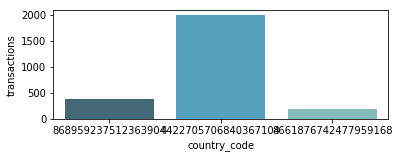

In [135]:
country_code = data[['country_code','prospect_id']].groupby('country_code').count().rename(columns={'prospect_id':'transactions'}).reset_index()
plt.figure(figsize=(6,2))
sns.barplot(x='country_code',y='transactions', data=country_code, palette=sns.color_palette("GnBu_d",3));
print("Transaction counts by country")

### **Transactions count by buildings**
* data from every country is shown separately

In [12]:
def plot_building(data, country):
    data = data[data['country_code'] == country].sort_values(by='transactions', ascending=False).reset_index(drop=True)
    plt.figure(figsize=(12,3))
    fig = sns.barplot(y='transactions',x='building', data=data, order=data['building'], palette=sns.cubehelix_palette(len(data),reverse=True))
    print("Transaction counts by building, in country {}".format(country))

Transaction counts by building, in country 8661876742477959168


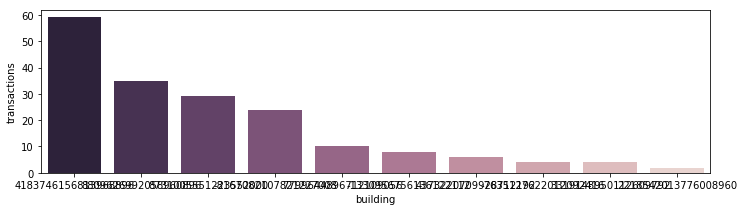

In [13]:
cc = data['country_code'].unique()
cc_building = data[['country_code','building','prospect_id']].groupby(['country_code','building']).count().rename(columns={'prospect_id':'transactions'}).reset_index()
plot_building(cc_building, cc[2])

Transaction counts by building, in country 4422705706840367104


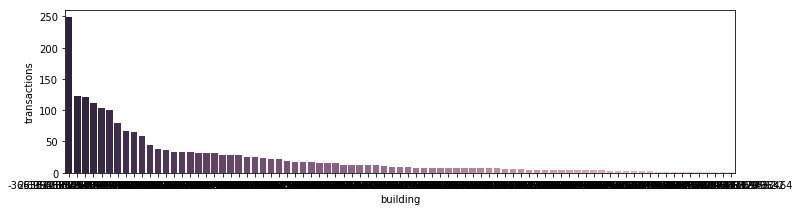

In [14]:
plot_building(cc_building, cc[0])

Transaction counts by building, in country 868959237512363904


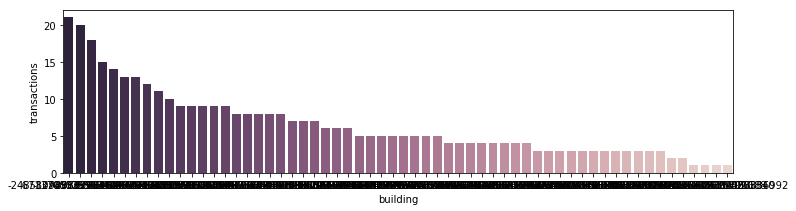

In [15]:
plot_building(cc_building, cc[1])

### **Transactions count by customer**
* 87% customers are 1st-time
* 11% 2nd-time
* Max: 1 customer had 44 transactions

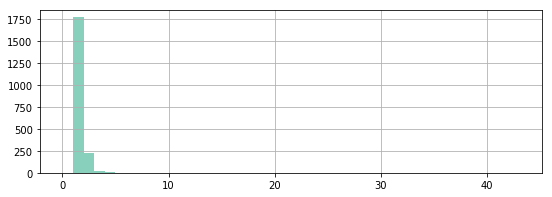

In [69]:
cust_invoice_count = data['customer_invoice_name'].value_counts()
cust_invoice_count.hist(bins=range(0,cust_invoice_count.max()), figsize=(9,3), color='#88d0bb');

In [102]:
pd.DataFrame(cust_invoice_count.value_counts().reset_index())\
.rename(columns={"index":"num_of_transactions","customer_invoice_name":"num_of_customers"})\
.sort_values(by=['num_of_transactions'])

,num_of_transactions,num_of_customers
0,1,1763
1,2,227
2,3,26
3,4,5
4,5,2
11,6,1
10,8,1
9,9,1
5,10,2
7,13,1
